In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision import models

from datasets import ImagenetDataset
from fooling_model import VGG16FoolingModel, VGG19FoolingModel, ResNet50FoolingModel
from utils import construct_perturbation, calculate_fooling_rate, process_image

In [2]:
np.random.seed(2)
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True

In [3]:
BATCH_SIZE = 64
MAX_PERTURB_NORM = 10
p = np.inf

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

imgs_dir = 'imgs'
imgs_paths = [os.path.join(imgs_dir, img_name) for img_name in os.listdir(imgs_dir)]
train_paths = np.random.choice(imgs_paths, size=BATCH_SIZE, replace=False)
val_paths = list(set(imgs_paths) - set(train_paths))
train_dataset = ImagenetDataset(train_paths, device)
val_dataset = ImagenetDataset(val_paths, device)

In [4]:
fooling_model = VGG19FoolingModel(models.vgg19(pretrained=True)).to(device)
fooling_model.eval();

In [ ]:
q_pool = list(range(1, 11))
fooling_rates = []
perturbations = []
train_batch = train_dataset[:]

for q in q_pool:
    print('norm', q)
    perturbation = construct_perturbation(
        model=fooling_model,
        layer_id=fooling_model.LAYERS_IDS['block2_pool'],
        train_batch=train_batch,
        perturb_norm=MAX_PERTURB_NORM,
        p=p,
        q=q
    )
    fooling_rate = calculate_fooling_rate(
        model=fooling_model,
        perturbation=perturbation,
        val_data=val_dataset
    )
    fooling_rates.append(fooling_rate)
    perturbations.append(perturbation.cpu())

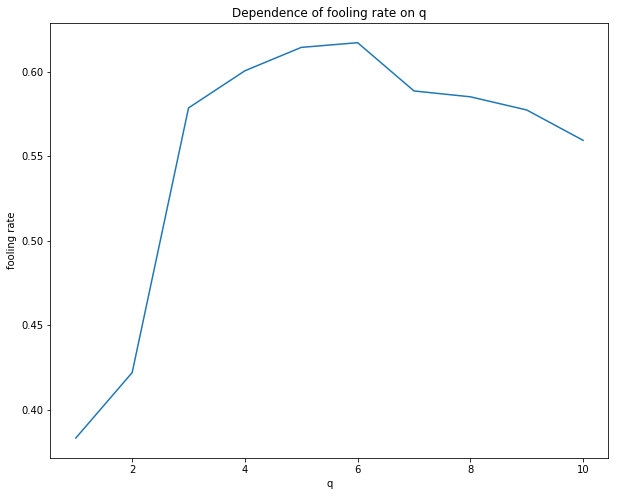

In [10]:
plt.figure(figsize=(10, 8))
plt.title('Dependence of fooling rate on q')
plt.xlabel('q')
plt.ylabel('fooling rate')
plt.plot(q_pool, fooling_rates, label='non-smoothed')

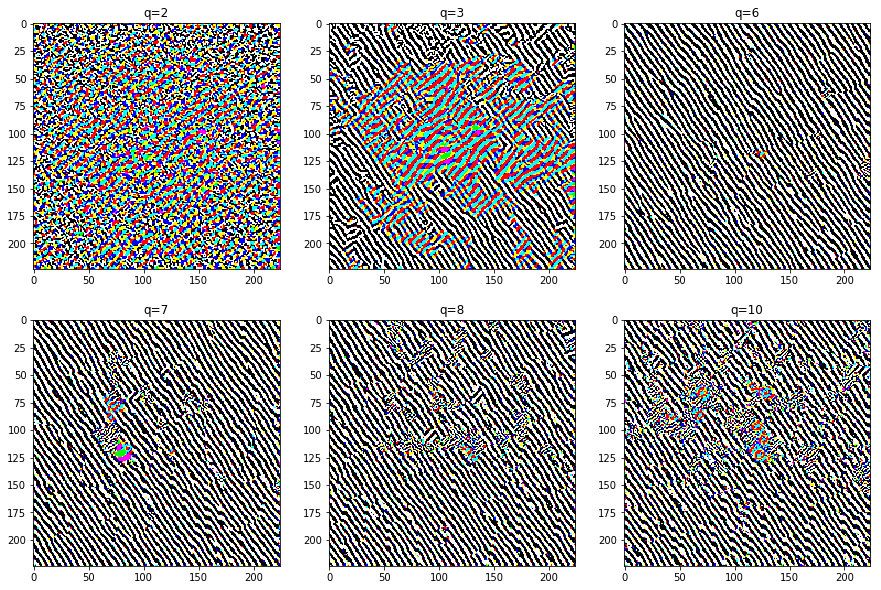

In [13]:
plt.figure(figsize=(3 * 5, 2 * 5))
random_q_idxs = sorted(np.random.choice(len(q_pool), replace=False, size=6))
for plot_idx, q_idx in enumerate(random_q_idxs, 1):
    bs = q_pool[q_idx]
    perturbation = perturbations[q_idx]
    plt.subplot(2, 3, plot_idx)
    plt.title('q={}'.format(bs))
    plt.imshow(process_image(perturbation))